In [355]:
# Imports
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import uuid
import mlflow
import mlflow.sklearn

from datetime import datetime

from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, root_mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [356]:
# Directory config to project root to insure consistency across environments for project specific imports
from pyprojroot import here
os.chdir(here())

# Project specific imports
from src.utils import save_dataframe

In [357]:
target = 'revenue'

In [358]:
# # Load dataset
# data = pd.read_csv("./data/1.1_imputed_data_full.csv")

# # Data filters
# # data = data.dropna(subset=['revenue'])
# # data = data[data["budget_missing"] == 0]
# data = data[data["revenue_missing"] == 0]
# # data = data[data["budget_missing"] == 0 & data["revenue_missing"] == 0]
# # data = data[(data["budget_missing"] == 0) & (data["revenue_missing"] == 0)]

# # Split X/y
# X = data.drop(columns=[target])
# y = data[target]

# # Train/Test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [359]:
# X_train.info()

In [360]:
# Load dataset
data = pd.read_csv("./data/1.2_imputed_data_no_revenue.csv")

# Data filters
data = data.dropna(subset=['revenue'])
# data = data[data["budget_missing"] == 0]
# data = data[data["revenue_missing"] == 0]
# data = data[data["budget_missing"] == 0 & data["revenue_missing"] == 0]
# data = data[(data["budget_missing"] == 0) & (data["revenue_missing"] == 0)]

# Split X/y
X = data.drop(columns=[target])
y = data[target]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [361]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4690 entries, 320 to 1546
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   metascore                       4690 non-null   float64
 1   rotten_tomatoes_rating          4690 non-null   float64
 2   meta_critic_rating              4690 non-null   float64
 3   budget                          4690 non-null   float64
 4   metascore_missing               4690 non-null   int64  
 5   rotten_tomatoes_rating_missing  4690 non-null   int64  
 6   meta_critic_rating_missing      4690 non-null   int64  
 7   budget_missing                  4690 non-null   int64  
 8   total_wins                      4690 non-null   int64  
 9   total_noms                      4690 non-null   int64  
 10  oscar_wins                      4690 non-null   int64  
 11  oscar_noms                      4690 non-null   int64  
 12  bafta_wins                      4690 

In [362]:
X_train = pd.read_csv("./data/1.3.1_X_train_imputed.csv")
X_test = pd.read_csv("./data/1.3.2_X_test_imputed.csv")
y_train = pd.read_csv("./data/1.3.3_y_train.csv")
y_test = pd.read_csv("./data/1.3.4_y_test.csv")

In [363]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4983 entries, 0 to 4982
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   metascore                       4983 non-null   float64
 1   rotten_tomatoes_rating          4983 non-null   float64
 2   meta_critic_rating              4983 non-null   float64
 3   budget                          4983 non-null   float64
 4   metascore_missing               4983 non-null   int64  
 5   rotten_tomatoes_rating_missing  4983 non-null   int64  
 6   meta_critic_rating_missing      4983 non-null   int64  
 7   budget_missing                  4983 non-null   int64  
 8   total_wins                      4983 non-null   int64  
 9   total_noms                      4983 non-null   int64  
 10  oscar_wins                      4983 non-null   int64  
 11  oscar_noms                      4983 non-null   int64  
 12  bafta_wins                      49

In [364]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4983 entries, 0 to 4982
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  4983 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB


## Multilable Binarizer

In [365]:
def apply_mlb_for_feature(df: pd.DataFrame, feature: str, delimiter: str = ",") -> pd.DataFrame:
    """
    Applies MultiLabelBinarizer to a single multi-label column and returns a new DataFrame 
    with the original column replaced by its one-hot encoded dummy columns.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the column to encode.
        delimiter (str): The delimiter used in the column to separate values (default: ", ").
    
    Returns:
        pd.DataFrame: A new DataFrame with the specified feature replaced by one-hot encoded columns.
    """
    df = df.copy()
    
    # Create a new column that is a list of values from the original column
    list_col = feature + "_list"
    df[list_col] = df[feature].apply(lambda x: [i.strip() for i in x.split(delimiter)] if pd.notnull(x) else [])
    
    # Initialize and fit MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    dummies = pd.DataFrame(
        mlb.fit_transform(df[list_col]),
        columns=[f"{feature}_{cls}" for cls in mlb.classes_],
        index=df.index
    )
    
    # Concatenate the dummy columns to the DataFrame and drop the original columns
    df = pd.concat([df, dummies], axis=1).drop([feature, list_col], axis=1)
    return df

# Function to apply MultiLabelBinarizer for multiple features
def apply_mlb_for_features(df: pd.DataFrame, features: list, delimiter: str = ",") -> pd.DataFrame:
    for feature in features:
        df = apply_mlb_for_feature(df, feature, delimiter)
    return df

# List of multi-label features
mlb_features = ['genre_names', 'production_country_name', 'spoken_languages']

# Create a FunctionTransformer
mlb_transformer = FunctionTransformer(func=apply_mlb_for_features, kw_args={'features': mlb_features})

In [366]:
num_cols = make_column_selector(dtype_include=['number'])
num_cols = num_cols(data)

for col in num_cols:
    print(col)

metascore
rotten_tomatoes_rating
meta_critic_rating
budget
metascore_missing
rotten_tomatoes_rating_missing
meta_critic_rating_missing
budget_missing
total_wins
total_noms
oscar_wins
oscar_noms
bafta_wins
bafta_noms
release_year
release_month
release_day
is_weekend
is_holiday_season
movie_age
imdb_rating
imdb_votes
tmdb_vote_count
tmdb_vote_average
runtime_in_min
tmdb_popularity
revenue


In [367]:
cat_cols = make_column_selector(dtype_include=['object'])
cat_cols = cat_cols(data)

# for col in cat_cols:
#     print(col)

print(cat_cols)

['release_date', 'production_country_name', 'spoken_languages', 'first_billing_actor', 'second_billing_actor', 'third_billing_actor', 'main_director', 'main_writer', 'secondary_writer', 'title', 'genre_names', 'production_company_name', 'age_rating']


In [368]:
# ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# ohe.set_output(transform="default")

# scaler = StandardScaler()

In [369]:
modeling_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [
            'metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'tmdb_vote_count', 'tmdb_vote_average', 'runtime_in_min', 
            'tmdb_popularity', 'imdb_rating', 'imdb_votes', 'total_wins', 'total_noms', 'oscar_wins', 'oscar_noms', 'bafta_wins', 'bafta_noms', 
            'release_year', 'release_month', 'release_day', 'movie_age', 
            # 'roi', 'revenue'
            ]),
        ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['age_rating']),
        ('OrdinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999999), ['first_billing_actor', 'second_billing_actor', 'third_billing_actor', 'main_director', 'main_writer', 'secondary_writer'])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False,
)

# Set output to pandas dataframe
modeling_transformer.set_output(transform='pandas')

# transformed_data = modeling_transformer.fit_transform(data)
# transformed_data.head()

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['metascore', 'rotten_tomatoes_rating',
                                  'meta_critic_rating', 'budget',
                                  'tmdb_vote_count', 'tmdb_vote_average',
                                  'runtime_in_min', 'tmdb_popularity',
                                  'imdb_rating', 'imdb_votes', 'total_wins',
                                  'total_noms', 'oscar_wins', 'oscar_noms',
                                  'bafta_wins', 'bafta_noms', 'release_year',
                                  'relea...',
                                  'movie_age']),
                                ('OneHotEncoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['age_rating']),
                                ('OrdinalEncoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=999999),
                                 ['first_billing_actor', 'second_billing_actor',
                                  'third_billing_actor', 'main_director',
                                  'main_writer', 'secondary_writer'])],
                  verbose_feature_names_out=False)

In [370]:
# Define a function transformer to drop unwanted columns.
def drop_unwanted_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    return df.drop(columns=columns, errors='ignore')

columns_to_drop = ['production_company_name', 'director', 'writer', 'actors', 'title', 'release_date']

dropper = FunctionTransformer(drop_unwanted_columns, kw_args={'columns': columns_to_drop})

In [371]:
scaling_pipeline = Pipeline(steps=[
    ('modeling_transformer', modeling_transformer),
    ('mlb', mlb_transformer),
    ('dropper', dropper)
])

# scaled_data = scaling_pipeline.fit_transform(data)
# scaled_data.info()

In [372]:
# scaled_data.head()

In [373]:
# Saving cleaned dataset for future use
# save_dataframe(scaled_data, "03_modeling_data.csv")

In [374]:
# target = 'revenue'
# X = data.drop(columns=[target])
# y = data[target]

In [375]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [376]:
# Fit the pipeline on the training data
X_train_scaled = scaling_pipeline.fit_transform(X_train, y_train)

# Transform the test data using the same pipeline
X_test_scaled = scaling_pipeline.transform(X_test)

In [377]:
X_train_scaled.head()

,metascore,rotten_tomatoes_rating,meta_critic_rating,budget,tmdb_vote_count,tmdb_vote_average,runtime_in_min,tmdb_popularity,imdb_rating,imdb_votes,...,production_country_name_Germany,production_country_name_Others,production_country_name_United Kingdom,production_country_name_United States of America,spoken_languages_English,spoken_languages_French,spoken_languages_German,spoken_languages_Italian,spoken_languages_Others,spoken_languages_Spanish
0,-0.706620,-1.139056,-0.707581,-0.293102,-0.452143,-0.585109,-0.401558,-0.080498,-0.686944,-0.398826,...,0,0,0,1,1,0,0,0,1,0
1,-0.476524,-1.102331,-0.477312,-0.358945,-0.474932,-0.604571,-0.506534,-0.198669,-0.896128,-0.457147,...,0,0,0,1,1,0,0,0,0,0
2,-0.062353,0.036162,-0.062829,-0.446736,-0.400399,1.035397,-0.663999,-0.056023,0.254386,-0.527172,...,0,1,0,1,1,0,0,0,0,0
3,-0.338467,-0.257643,-0.339151,1.462709,0.488102,-0.400872,0.805675,-0.036052,-0.582352,-0.069081,...,0,1,0,1,1,0,0,0,0,0
4,0.121723,-0.294368,0.121386,-0.136686,-0.586464,1.211849,0.595721,-0.196417,0.881939,-0.558171,...,1,1,1,0,1,1,0,0,1,0


In [378]:
def model_evaluation(models: dict, X_train, y_train, w_train=None):
    """
    Evaluates regression models using Cross Validation.
    Returns a report with R² and RMSE scores.
    """
    
    evaluation_report = {}

    for model_name, model in models.items():
        # R² Score
        r2_scores = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=5, 
            scoring="r2", 
            n_jobs=-1
        )
        
        # RMSE Score
        rmse_scores = cross_val_score(
            model, X_train, y_train, 
            cv=5, 
            scoring=make_scorer(lambda y, y_pred: root_mean_squared_error(y, y_pred)), 
            n_jobs=-1
        )

        # Store results
        evaluation_report[model_name] = {
            "R² Mean": np.mean(r2_scores),
            "RMSE Mean": np.mean(rmse_scores)
        }
        
        # Print results
        print(f"{model_name}:")
        print(f"- CV R² scores: {' | '.join([f'{r * 100:.1f}%' for r in r2_scores])}")
        print(f"- Mean R²: {np.mean(r2_scores) * 100:.1f}%")
        print("- -----------------------------------------------------------------------------------------------------------")
        print(f"- CV RMSE scores: {' | '.join([f'{r:,.0f}$' for r in rmse_scores])}")
        print(f"- Mean RMSE: {np.mean(rmse_scores):,.0f}$")
        print()


    
    return evaluation_report

models = {
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "LightGBM Regressor": LGBMRegressor(random_state=42),
    # "KNeighbors Regressor": KNeighborsRegressor(),
    # "SVR": SVR()
}


In [379]:
_ = model_evaluation(models, X_train_scaled, y_train)

Random Forest Regressor:
- CV R² scores: 78.7% | 75.9% | 78.8% | 76.7% | 72.0%
- Mean R²: 76.4%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 101,136,824$ | 96,352,570$ | 86,814,086$ | 91,419,770$ | 103,761,994$
- Mean RMSE: 95,897,049$

Gradient Boosting Regressor:
- CV R² scores: 81.7% | 78.3% | 83.5% | 73.5% | 73.5%
- Mean R²: 78.1%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 93,821,871$ | 91,441,998$ | 76,580,838$ | 97,417,298$ | 101,032,500$
- Mean RMSE: 92,058,901$

XGBoost Regressor:
- CV R² scores: 75.3% | 77.6% | 80.8% | 78.0% | 71.9%
- Mean R²: 76.7%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 108,945,702$ | 92,842,296$ | 82,557,076$ | 88,840,057$ | 104,045,312$
- Mean RMSE: 95,446,089$

LightGBM Regressor:
- CV R² scores: 82.1% |

In [380]:
def tune_params_regression(model, X_train, X_test, y_train, y_test, param_grid, scoring='r2'):
    """
    Evaluates a regression model using cross-validation and logs parameters and metrics with MLflow.
    Returns the best estimator.
    
    Parameters
    ----------
    model : estimator
        The regression model instance.
    X_train, X_test : DataFrame or array-like
        Training and testing features.
    y_train, y_test : array-like
        Training and testing target values.
    param_grid : dict
        The grid of parameters for GridSearchCV.
    scoring : str, default='r2'
        The scoring metric for GridSearchCV.
        
    Returns
    -------
    best_model : estimator
        The best estimator found by GridSearchCV.
    """
    # Define an experiment name using model type and timestamp.
    experiment_name = f"Exp_{model.__class__.__name__}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    mlflow.set_experiment(experiment_name)

    # Define a custom run name and run_id.
    run_name = f"{model.__class__.__name__}_Run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    run_id = f"{model.__class__.__name__}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{str(uuid.uuid4())[:8]}"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("model_type", model.__class__.__name__)
        
        # Initialize GridSearchCV for regression.
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scoring,
            cv=5,
            n_jobs=-1
        )
        
        # Fit the model on the training data.
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Predict on the test set.
        y_pred = best_model.predict(X_test)
        
        # Compute R² and RMSE.
        r2 = r2_score(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        
        # Log metrics to MLflow.
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_params(grid_search.best_params_)
        mlflow.sklearn.log_model(best_model, f"Tuned_{model.__class__.__name__}", input_example=X_train.iloc[:20])
        
        # Print out the results.
        r2_formatted = f"{r2 * 100:.1f}%"
        rmse_formatted = f"{rmse:,.0f}$"
        print("----------------------------------------")
        print(f"- R² Score: {r2_formatted}")
        print(f"- RMSE: {rmse_formatted}")
        print("----------------------------------------")
        print("Best Parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"- {param}: {value}")
        print("----------------------------------------")
        
        return best_model


In [381]:
# param_grid_rf = {
#     'n_estimators': [100, 300, 500],  
#     'max_depth': [None, 10, 20, 30],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4],  
#     'max_features': ['auto', 'sqrt', 'log2']  
# }

# rf = RandomForestRegressor(random_state=42)

# # Example: Tuning a Random Forest Regressor
# best_rf = tune_params_regression(
#     model=rf,
#     X_train=X_train_scaled, 
#     X_test=X_test_scaled,
#     y_train=y_train, 
#     y_test=y_test,
#     param_grid=param_grid_rf,
#     scoring='r2'
# )


In [382]:
# Init a Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Define parameter grid
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Tune model
best_gbr = tune_params_regression(
    gbr,
    X_train_scaled, 
    X_test_scaled,
    y_train, 
    y_test,
    param_grid_gbr
)


2025/02/24 15:45:41 INFO mlflow.tracking.fluent: Experiment with name 'Exp_GradientBoostingRegressor_2025-02-24_15-45-41' does not exist. Creating a new experiment.
c:\Users\ksbon\Desktop\Programing\Are-You-Not-Entertained\venv\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- genre_names_TV Movie


In [ ]:
# Init a XGBoost Regressor
lgbm = LGBMRegressor(random_state=42)

# Set parameter grid
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'subsample': [0.8, 1.0]
}

# Tune model
best_lgbm = tune_params_regression(
    lgbm,
    X_train_scaled, 
    X_test_scaled,
    y_train, 
    y_test,
    param_grid_lgbm
)

2025/02/24 15:18:16 INFO mlflow.tracking.fluent: Experiment with name 'Exp_LGBMRegressor_2025-02-24_15-18-16' does not exist. Creating a new experiment.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4131
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 71
[LightGBM] [Info] Start training from score 103185339.444894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

ValueError: Number of features of the model must match the input. Model n_features_ is 79 and input n_features is 78

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 300, 500],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    'subsample': [0.7, 0.8, 1.0],  
    'colsample_bytree': [0.7, 0.8, 1.0],  
    'gamma': [0, 0.1, 0.2],  
    'reg_lambda': [1, 5, 10]  
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

# Example: Tuning an XGBoost Regressor
# best_xgb = tune_params_regression(
#     model=xgb,
#     X_train=X_train_scaled, 
#     X_test=X_test_scaled,
#     y_train=y_train, 
#     y_test=y_test,
#     param_grid=param_grid_xgb,
#     scoring='r2'
# )


In [ ]:
y_pred_lgbm = best_lgbm.predict(X_test_scaled)
# y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_gbr = best_gbr.predict(X_test_scaled)

NameError: name 'best_rf' is not defined

In [ ]:
def evaluate_model(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred) * 100  # Convert to percentage
    rmse = root_mean_squared_error(y_true, y_pred)  # Root Mean Squared Error
    print(f"{model_name}:")
    print(f"  - R² Score: {r2:.1f}%")
    print(f"  - RMSE: {rmse:,.0f}$\n")

evaluate_model("LightGBM", y_test, y_pred_lgbm)
# evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Gradient Boosting", y_test, y_pred_gbr)


LightGBM:
  - R² Score: 73.8%
  - RMSE: 131,347,275$

Random Forest:
  - R² Score: 65.1%
  - RMSE: 151,506,399$

Gradient Boosting:
  - R² Score: 70.0%
  - RMSE: 140,655,701$



c:\Users\ksbon\Desktop\Programing\Are-You-Not-Entertained\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ksbon\Desktop\Programing\Are-You-Not-Entertained\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ksbon\Desktop\Programing\Are-You-Not-Entertained\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


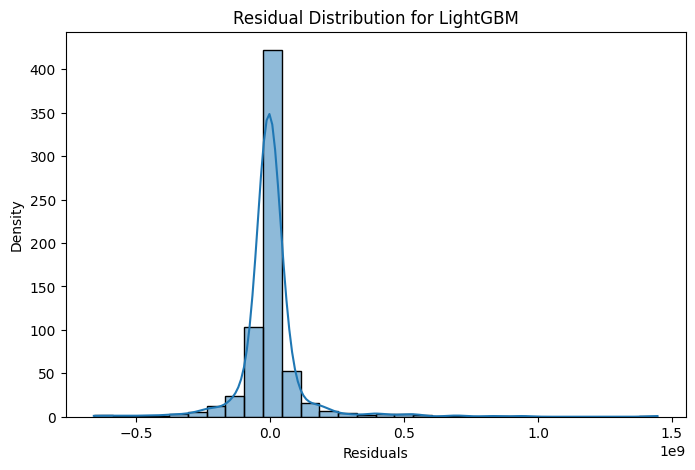

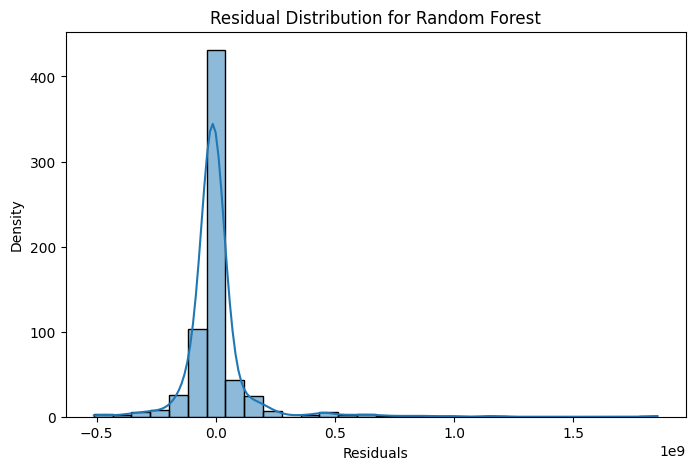

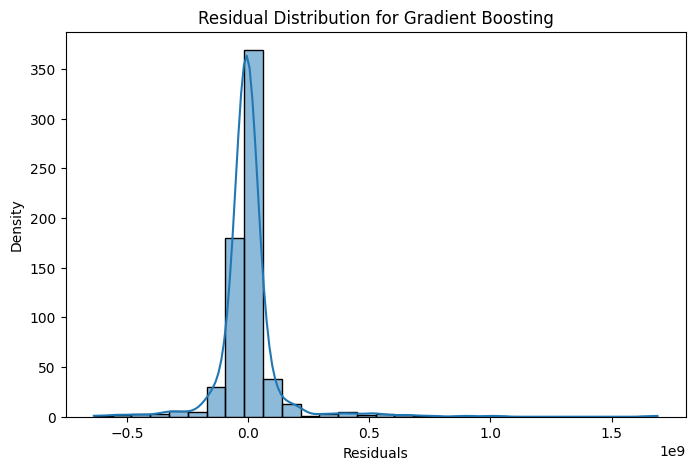

In [ ]:
import seaborn as sns

def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title(f"Residual Distribution for {model_name}")
    plt.show()

plot_residuals(y_test, y_pred_lgbm, "LightGBM")
# plot_residuals(y_test, y_pred_rf, "Random Forest")
plot_residuals(y_test, y_pred_gbr, "Gradient Boosting")


In [ ]:
def display_feature_importances(model, dataframe):
    # Get feature importance
    importance_df = pd.DataFrame({
        'Feature': dataframe.columns,
        'Importance': model.feature_importances_
    })

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the top most important features
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Top Feature Importances from {type(model).__name__}')
    plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
    plt.show()

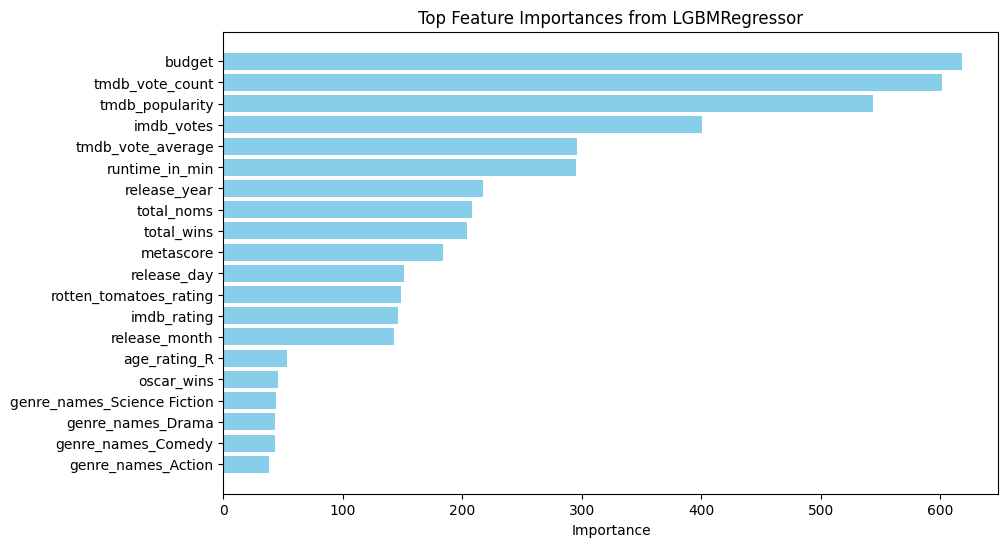

In [ ]:
display_feature_importances(best_lgbm, X_train_scaled)

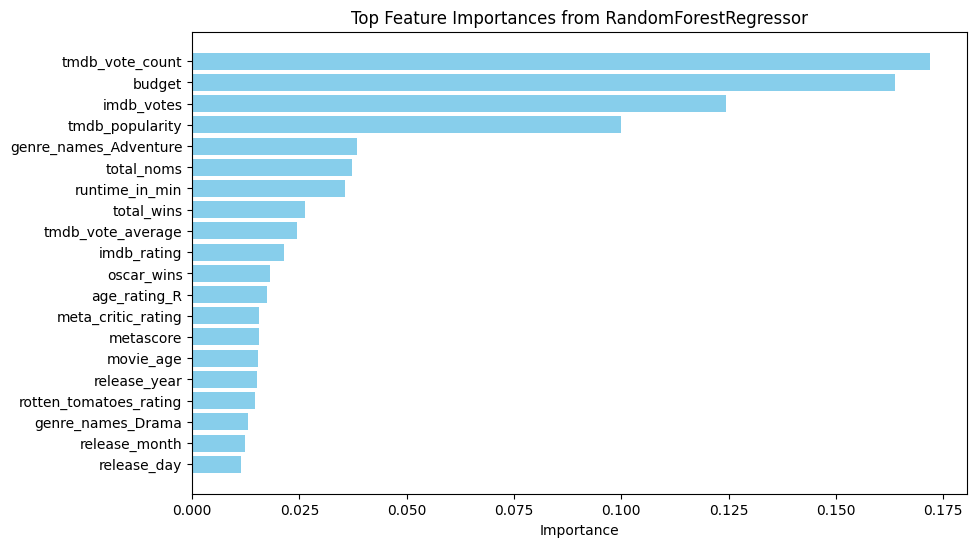

In [ ]:
display_feature_importances(best_rf, X_train_scaled)